In [37]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt



# for plotting
plotFontSize = 18.0
legendFontSize = 0.75*plotFontSize

font = {'family' : 'serif',
        'weight' : 'normal',
        'size' : plotFontSize}

matplotlib.rc('font', **font)

In [38]:
### User input.

zMin = 0.0
zMax = 1000.0
dz = 5.0

z0 = 0.1
kappa = 0.4
uStar = 0.5




In [39]:
### Create the cell-centered mesh points and face points.

nz = int((zMax - zMin)/dz)
zCell = np.zeros((nz,))
zFace = np.zeros((nz+1,))

for k in range(nz):
    zCell[k] = 0.5*dz + k*dz
    
for k in range(nz + 1):
    zFace[k] = k*dz
    
# force the first face to be at z0 instead of 0.
zFace[0] = zMin + z0

    
    
    
    

In [40]:
### Set a log profile.

zExact = np.linspace(z0,zMax,10001)
uExact = (uStar/kappa) * np.log((zExact-zMin)/z0)
uCell = (uStar/kappa) * np.log((zCell-zMin)/z0)
uFace = (uStar/kappa) * np.log((zFace-zMin)/z0)




In [41]:
### Compute phi_m with standard centered differencing.  Do this in a finite-volume framework in which
### we say we have cell-center value of velocity, so we linearly interpolate to faces and difference across 
### faces.  For uniform grids, this is equivalent to standard 2nd-order central finite-differencing.

# Do the interpolation to faces.
uFaceInterpolated = np.zeros((nz+1,))
for i in range(nz+1):
    # Set the lower face value at z0 to 0.0 following the log law.
    if (i == 0):
        uFaceInterpolated[i] = 0.0
        
    # Do one-sided differencing at upper boundary.
    elif (i == nz):
        uFaceInterpolated[i] = 1.5*uCell[-1] - 0.5*uCell[-2]
        
    # For all other cells, do linear interpolation accounting for unequal spacing if present.
    else:
        dz_ip1 = zCell[i] - zFace[i]
        dz_im1 = zFace[i] - zCell[i-1]
        denom = dz_ip1 + dz_im1
            
        uFaceInterpolated[i] = (dz_im1*uCell[i] + dz_ip1*uCell[i-1])/denom
        
        
# Difference across faces to get du/dz at cell centers.  Do so to account for unequal spacing if present.
dudz = np.zeros((nz,))
for i in range(nz):
    dz_ip1 = zFace[i+1] - zCell[i]
    dz_im1 = zCell[i] - zFace[i]
    df_ip1 = uFaceInterpolated[i+1] - uCell[i]
    df_im1 = uCell[i] - uFaceInterpolated[i]
    denom = 2.0*dz_ip1*dz_im1

    dudz[i] = (dz_im1*df_ip1 + dz_ip1*df_im1)/denom
    

# Compute phi_m.
phim = np.zeros((nz,))
for i in range(nz):
    phim[i] = (kappa*zCell[i]/uStar) * dudz[i]




In [42]:
### Compute phi_m with log-based centered differencing.  Do this in a finite-volume framework in which
### we say we have cell-center value of velocity, so we log-linearly interpolate to faces and difference across 
### faces in log space.  This is equivalent to standard 2nd-order central finite-differencing in log space.

# Since we will be working in log space, make a z' coordinate where z' = ln(z)
zCellLog = np.log(zCell)
zFaceLog = np.log(zFace)


# Do the interpolation to faces.
uFaceInterpolatedLog = np.zeros((nz+1,))
for i in range(nz+1):
    # Set the lower face value at z0 to 0.0 following the log law.
    if (i == 0):
        uFaceInterpolatedLog[i] = 0.0
        
    # Do one-sided differencing at upper boundary.  (Note that out of laziness, I'm not doing this one face
    # in log space because it doesn't really matter all the way at the top of the profile...)
    elif (i == nz):
        uFaceInterpolatedLog[i] = 1.5*uCell[-1] - 0.5*uCell[-2]
        
    # For all other cells, do linear interpolation accounting for unequal spacing if present.
    else:
        dz_ip1 = zCellLog[i] - zFaceLog[i]
        dz_im1 = zFaceLog[i] - zCellLog[i-1]
        denom = dz_ip1 + dz_im1
            
        uFaceInterpolatedLog[i] = (dz_im1*uCell[i] + dz_ip1*uCell[i-1])/denom
        
        
# Difference across faces to get du/dz' at cell centers.  Do so to account for unequal spacing if present.
# But, ultimately we want du/dz, so we are ultimately doing du/dz = du/dz' * dz'/dz.  dz'/dz is just the
# derivative of ln(z) with respect to z, which is 1/z.  Make sure to multiply du/dz' by 1/z!
dudzLog = np.zeros((nz,))
for i in range(nz):
    dz_ip1 = zFaceLog[i+1] - zCellLog[i]
    dz_im1 = zCellLog[i] - zFaceLog[i]
    df_ip1 = uFaceInterpolatedLog[i+1] - uCell[i]
    df_im1 = uCell[i] - uFaceInterpolatedLog[i]
    denom = 2.0*dz_ip1*dz_im1

    #                1/z! I forgot this the first time :-).
    #                 |
    #                 V
    dudzLog[i] = (1.0/zCell[i])*(dz_im1*df_ip1 + dz_ip1*df_im1)/denom
    

# Compute phim.
phimLog = np.zeros((nz,))
for i in range(nz):
    phimLog[i] = (kappa*zCell[i]/uStar) * dudzLog[i]
    
    
    

(0.0, 100.0)

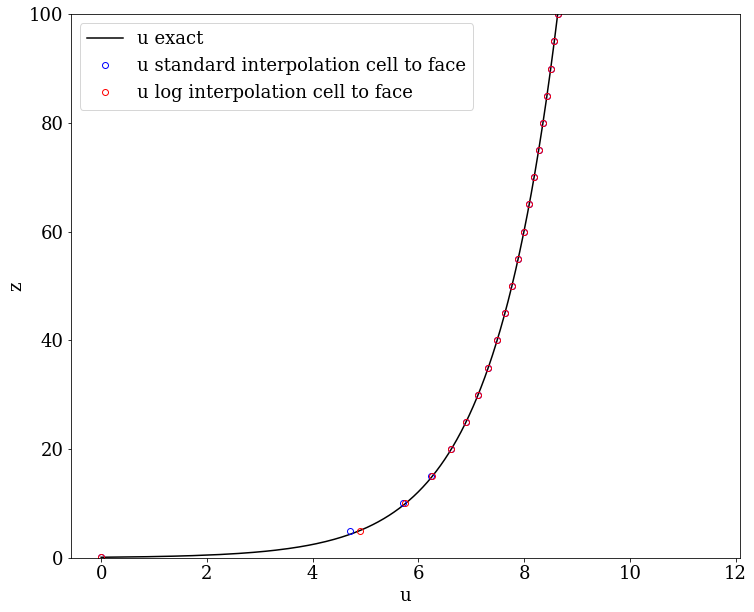

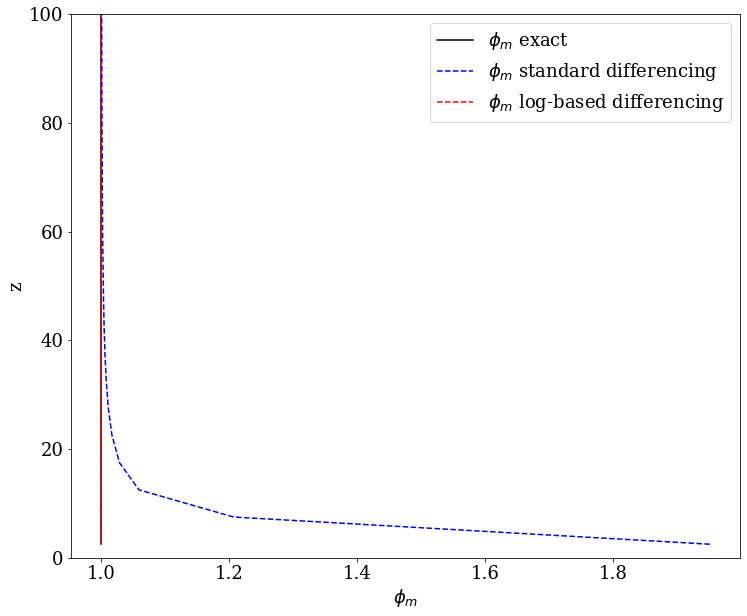

In [44]:
### Plot it to demonstrate that log-based is exact!  Standard has quite a lot of error near surface!

plt.figure(0,figsize=[12,10])
plt.plot(uExact,zExact,'k-')
plt.plot(uFaceInterpolated,zFace,'bo',markerfacecolor='none')
plt.plot(uFaceInterpolatedLog,zFace,'ro',markerfacecolor='none')
plt.xlabel('u')
plt.ylabel('z')
plt.legend(['u exact',
            'u standard interpolation cell to face',
            'u log interpolation cell to face'])
plt.ylim([0,100])

plt.figure(1,figsize=[12,10])
plt.plot(np.ones((nz,)),zCell,'k-')
plt.plot(phim,zCell,'b--')
plt.plot(phimLog,zCell,'r--')
plt.xlabel(r'$\phi_m$')
plt.ylabel('z')
plt.legend([r'$\phi_m$ exact',
            r'$\phi_m$ standard differencing',
            r'$\phi_m$ log-based differencing',])
plt.ylim([0,100])


